# Load

In [ ]:
pip install pyhdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.6/771.6 kB 7.8 MB/s eta 0:00:00


In [ ]:
pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 17.2 MB/s eta 0:00:00


In [ ]:
import os
import warnings
import datetime
import re
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
# import xarray as xr
# import rioxarray as rxr
from shapely.geometry import mapping, box
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from pyhdf.SD import SD, SDC
from tqdm import tqdm
## https://hdfeos.org/software/pyhdf.php
warnings.simplefilter('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [ ]:
def get_data_agg(data, n_blocks_to_reduce, func, q=None, return_data_reshaped=False, print_shapes=False):
    """
    args:
        func: ['mean', 'percentile']
        percentile: 0:100 inclusive
    """
    if print_shapes:
        print(f"data.shape: {data.shape}")
        print(f"n_blocks_total: {len(data.flatten()):,}")
    n_rows, n_cols = data.shape
    data_reshaped = data.reshape([
        n_rows//n_blocks_to_reduce,
        n_blocks_to_reduce,
        n_cols//n_blocks_to_reduce,
        n_blocks_to_reduce,
        ], )

    # print(f"data_reshaped.shape: {data_reshaped.shape}")
    # print(data_reshaped[0,:,0,:])
    # print(data_reshaped)

    if func=='mean':
        data_agg = np.mean(a=data_reshaped, axis=(1,3))
    if func=='percentile':
        data_agg = np.percentile(a=data_reshaped, q=q, axis=(1,3))
    if func=='std':
        data_agg = np.std(a=data_reshaped, axis=(1,3))

    data_agg=np.round(a=data_agg, decimals=0).astype(np.int16)

    if print_shapes:
        print(f"data_agg.shape: {data_agg.shape}")
        print(f"n_blocks_total reduced: {len(data_agg.flatten()):,}")
    if return_data_reshaped:
        return data_agg, data_reshaped
    else:
        return data_agg

def get_test_data(n_data_shape, n_blocks_to_reduce, ):

    n_blocks_per_row = int(n_data_shape/n_blocks_to_reduce)
    n_blocks_total = int(n_blocks_per_row * n_blocks_per_row)

    print(f"n_data_shape: ({n_data_shape:,} | {n_data_shape:,})")
    print(f"n_blocks_to_reduce: {n_blocks_to_reduce:,}")

    print(f"n_blocks_per_row: {n_blocks_per_row:,}")
    print(f"n_blocks_total: {n_blocks_total:,}")

    row = np.repeat(np.repeat(a=np.arange(0, n_blocks_per_row), repeats=n_blocks_to_reduce, axis=0)[np.newaxis, :], repeats=n_blocks_to_reduce, axis=0)
    test_data = row

    for i in range(int(n_blocks_per_row - 1)):
        row = np.repeat(
            np.repeat(
                a=np.arange(np.max(test_data)+1, np.max(test_data)+n_blocks_per_row+1),
                repeats=n_blocks_to_reduce,
                axis=0)[np.newaxis, :],
            repeats=n_blocks_to_reduce,
            axis=0)
        test_data = np.concatenate([test_data, row], axis=0)

    print(f"test_data.shape: {test_data.shape}")
    print(f"test_data.max(): {test_data.max()}")
    print(f"len(np.unique(test_data)): {len(np.unique(test_data))}")

    assert (test_data.max() + 1) == n_blocks_total
    assert n_blocks_total == len(np.unique(np.unique(test_data, axis=0), axis=1).flatten())
    assert n_blocks_per_row == np.unique(test_data, axis=1).shape[1]

    return test_data

# Files

In [ ]:
files = [file for file in os.listdir('/content/drive/MyDrive/propane/data') if 'MOD' in file if "h10" in file]
dates = [
    datetime.datetime.strptime(re.findall(r"A(20\d\d\d\d\d)", file)[0], "%Y%j")
    for file in files
]
print(f"len(files): {len(files):}")
print(f"len(dates): {len(dates)}")
file_dates = pd.DataFrame({
    'year': [date.year for date in dates],
    'month': [date.month for date in dates],
    'day': [date.day for date in dates],})

# print(file_dates.groupby(['year',])['day'].count())
# plt.figure(figsize=[22,4])
# # plt.bar(dates, np.ones(shape=len(dates)), )
# plt.plot(dates, np.ones(shape=len(dates)), ls='', marker='o')

len(files): 560
len(dates): 560


In [ ]:
path_base='/content/drive/MyDrive/propane/data/'
path='/content/drive/MyDrive/propane/data/MOD13Q1.A2000049.h10v08.061.2020041152607.hdf'
# path=path_base+files[0]
hdf = SD(path, SDC.READ)
print(hdf.datasets())

"""
TODO:
- need to include cloud cover in model
- maybe model vs both mean and median ndvi
-
"""
dir(hdf.select('250m 16 days NDVI'))
ndvi = hdf.select('250m 16 days NDVI')[:,:]

{'250m 16 days NDVI': (('YDim:MODIS_Grid_16DAY_250m_500m_VI', 'XDim:MODIS_Grid_16DAY_250m_500m_VI'), (4800, 4800), 22, 0), '250m 16 days EVI': (('YDim:MODIS_Grid_16DAY_250m_500m_VI', 'XDim:MODIS_Grid_16DAY_250m_500m_VI'), (4800, 4800), 22, 1), '250m 16 days VI Quality': (('YDim:MODIS_Grid_16DAY_250m_500m_VI', 'XDim:MODIS_Grid_16DAY_250m_500m_VI'), (4800, 4800), 23, 2), '250m 16 days red reflectance': (('YDim:MODIS_Grid_16DAY_250m_500m_VI', 'XDim:MODIS_Grid_16DAY_250m_500m_VI'), (4800, 4800), 22, 3), '250m 16 days NIR reflectance': (('YDim:MODIS_Grid_16DAY_250m_500m_VI', 'XDim:MODIS_Grid_16DAY_250m_500m_VI'), (4800, 4800), 22, 4), '250m 16 days blue reflectance': (('YDim:MODIS_Grid_16DAY_250m_500m_VI', 'XDim:MODIS_Grid_16DAY_250m_500m_VI'), (4800, 4800), 22, 5), '250m 16 days MIR reflectance': (('YDim:MODIS_Grid_16DAY_250m_500m_VI', 'XDim:MODIS_Grid_16DAY_250m_500m_VI'), (4800, 4800), 22, 6), '250m 16 days view zenith angle': (('YDim:MODIS_Grid_16DAY_250m_500m_VI', 'XDim:MODIS_Grid_16DA

# Test

In [ ]:
# test
n_blocks_to_reduce = int(10000/250) # 10,000m / 250m is how many of the data blocks to get to 10k
n_data_shape = ndvi.shape[0]

n_blocks_to_reduce = 5
n_data_shape = n_blocks_to_reduce * 8

test_data = get_test_data(
    n_data_shape=n_data_shape,
    n_blocks_to_reduce=n_blocks_to_reduce,
    )

print(test_data)

n_data_shape: (40 | 40)
n_blocks_to_reduce: 5
n_blocks_per_row: 8
n_blocks_total: 64
test_data.shape: (40, 40)
test_data.max(): 63
len(np.unique(test_data)): 64
[[ 0  0  0 ...  7  7  7]
 [ 0  0  0 ...  7  7  7]
 [ 0  0  0 ...  7  7  7]
 ...
 [56 56 56 ... 63 63 63]
 [56 56 56 ... 63 63 63]
 [56 56 56 ... 63 63 63]]


In [ ]:
data_agg, data_reshaped = get_data_agg(
    data=test_data,
    n_blocks_to_reduce=n_blocks_to_reduce,
    func='percentile',
    q=10,
    return_data_reshaped=True,
    )

print(f"data_reshaped.shape: {data_reshaped.shape}")
# for i in range(n_blocks_to_reduce):
#     print(data_reshaped[1,i,0,:])
data_agg

data_reshaped.shape: (8, 5, 8, 5)


array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62, 63]], dtype=int16)

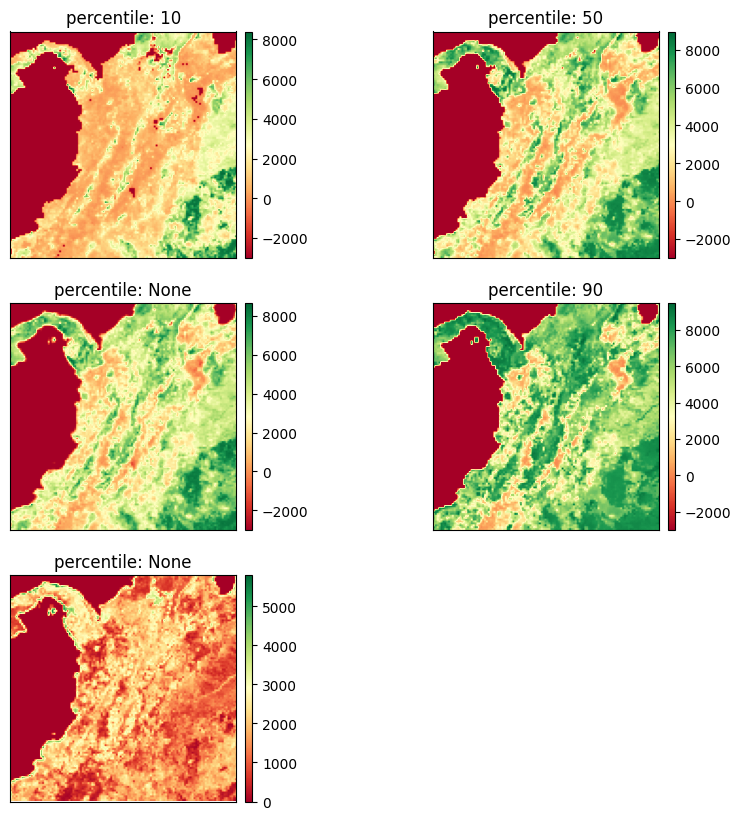

In [ ]:
km = 10
m = km * 1000
block_meters = 250

n_fig_size=10
plt.figure(figsize=[n_fig_size,n_fig_size])

for i, j in enumerate(zip(['percentile', 'percentile', 'mean', 'percentile', 'std'],[10, 50, None, 90, None])):
    func, q = j
    data_agg = get_data_agg(
        data=ndvi,
        n_blocks_to_reduce=int(m/block_meters),
        func=func,
        q=q,
        return_data_reshaped=False,
        print_shapes=False,
        )
    # print(f"percentile: {q}")
    ax=plt.subplot(3,2,i+1, )
    ep.plot_bands(data_agg, cmap='RdYlGn', figsize=(8,8), ax=ax, title=f"percentile: {q}")

# Shape File for Clipping

In [ ]:

#--------------------------------------------------------------
# Quality
#--------------------------------------------------------------
"""
-1 Fill/No Data Not Processed
0  Good Data Use with confidence
1  Marginal data Useful, but look at other QA information
2  Snow/Ice Target covered with snow/ice
3  Cloudy Target not visible, covered with cloud
"""
# qa, qa_array = clip_to_ghana_boundary(path=path, variable='250m 16 days pixel reliability')
# print(pd.Series(qa['250m 16 days pixel reliability'].data.flatten()).value_counts())

# ndvi, ndvi_array = clip_to_ghana_boundary(path=path, variable='250m 16 days NDVI')
# ep.plot_bands(qa['250m 16 days pixel reliability'], cmap='Greys_r')
# ep.plot_bands(ndvi['250m 16 days NDVI'], cmap='RdYlGn')

'\n-1 Fill/No Data Not Processed\n0  Good Data Use with confidence\n1  Marginal data Useful, but look at other QA information\n2  Snow/Ice Target covered with snow/ice\n3  Cloudy Target not visible, covered with cloud\n'

# Save Data

year
2000    20
2001    23
2002    23
2003    23
2004    23
2005    23
2006    23
2007    23
2008    23
2009    23
2010    23
2011    23
2012    23
2013    23
2014    23
2015    23
2016    23
2017    23
2018    23
2019    23
2020    23
2021    23
2022    23
2023    23
2024    11
Name: day, dtype: int64


,year,month,day
0,2002,9,30
1,2002,10,16
2,2002,11,1
3,2002,11,17
4,2002,12,3
...,...,...,...
555,2002,7,12
556,2002,7,28
557,2002,8,13
558,2002,8,29


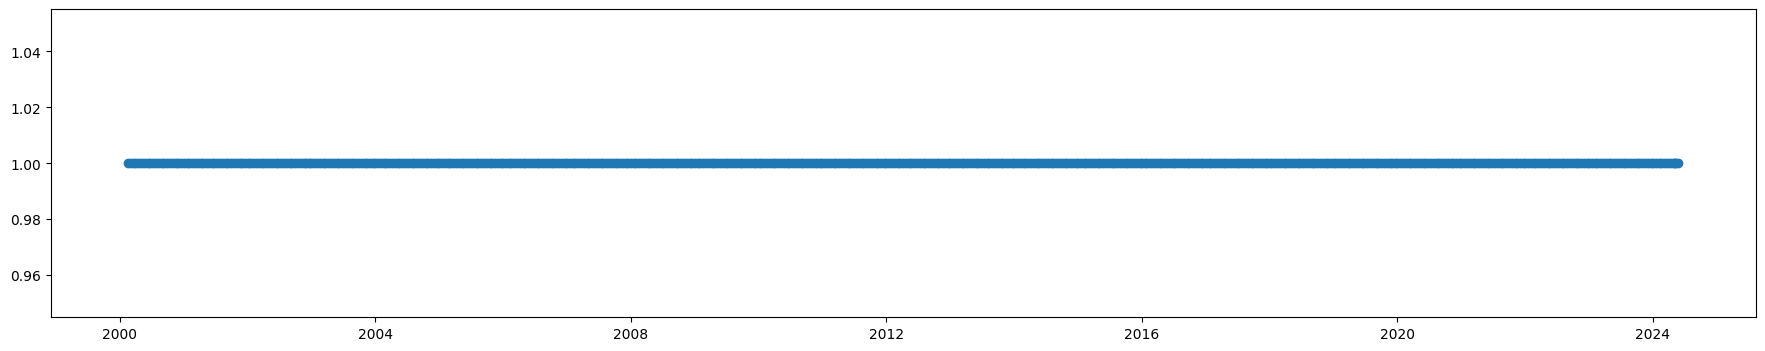

In [ ]:


print(file_dates.groupby(['year',])['day'].count())
plt.figure(figsize=[22,4])
# plt.bar(dates, np.ones(shape=len(dates)), )
plt.plot(dates, np.ones(shape=len(dates)), ls='', marker='o')
file_dates

In [ ]:
path_base_read='/content/drive/MyDrive/propane/data/'
paths_read = [path_base_read + file for file in files]; print(len(paths_read))

path_base_write='/content/drive/MyDrive/propane/data_agg/'
paths_save = [path_base_write + f"ndvi_{date.strftime('%Y%m%d')}.pickle" for date in dates]; paths_save
save_paths_qa = [path_base_write + f"qa_{date.strftime('%Y%m%d')}.pickle" for date in dates]; # save_paths_qa

560


In [ ]:
paths_read[0:3], dates[0:3]

(['/content/drive/MyDrive/propane/data/MOD13Q1.A2002273.h10v08.061.2020078024202.hdf',
  '/content/drive/MyDrive/propane/data/MOD13Q1.A2002289.h10v08.061.2020080025053.hdf',
  '/content/drive/MyDrive/propane/data/MOD13Q1.A2002305.h10v08.061.2020081093238.hdf'],
 [datetime.datetime(2002, 9, 30, 0, 0),
  datetime.datetime(2002, 10, 16, 0, 0),
  datetime.datetime(2002, 11, 1, 0, 0)])

# period_agg

(4800, 4800)


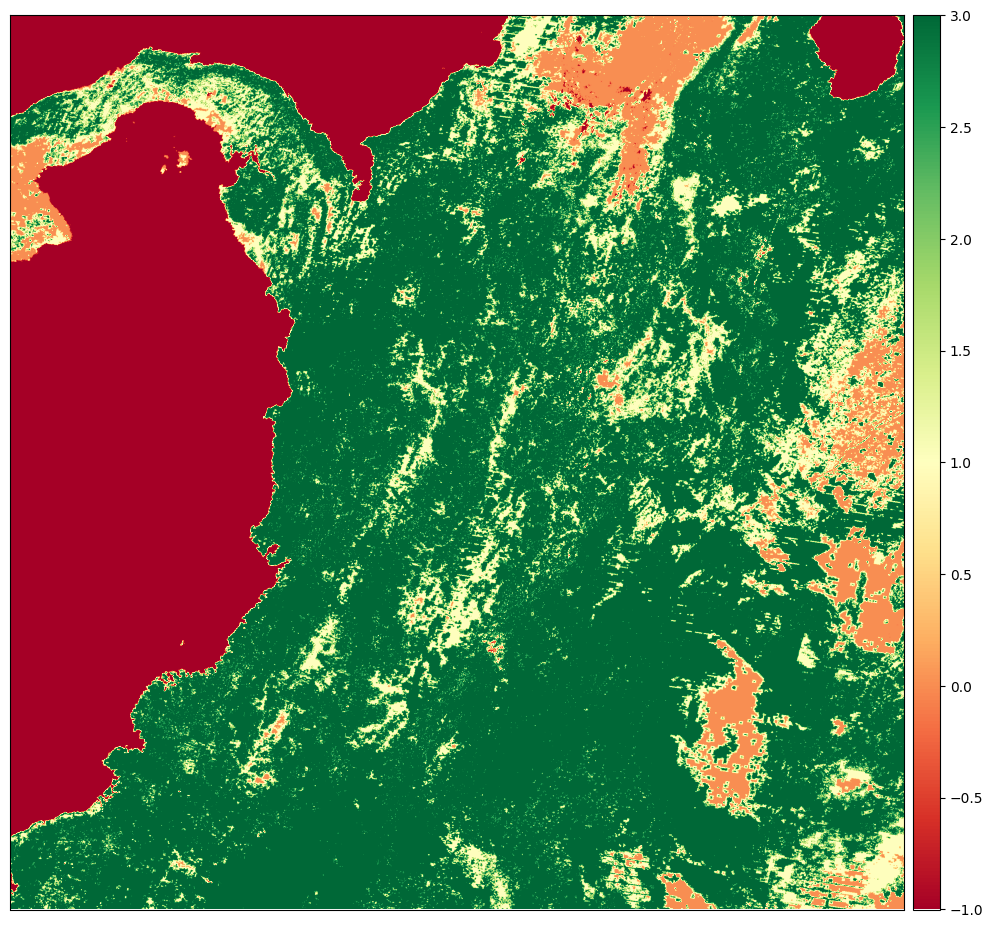

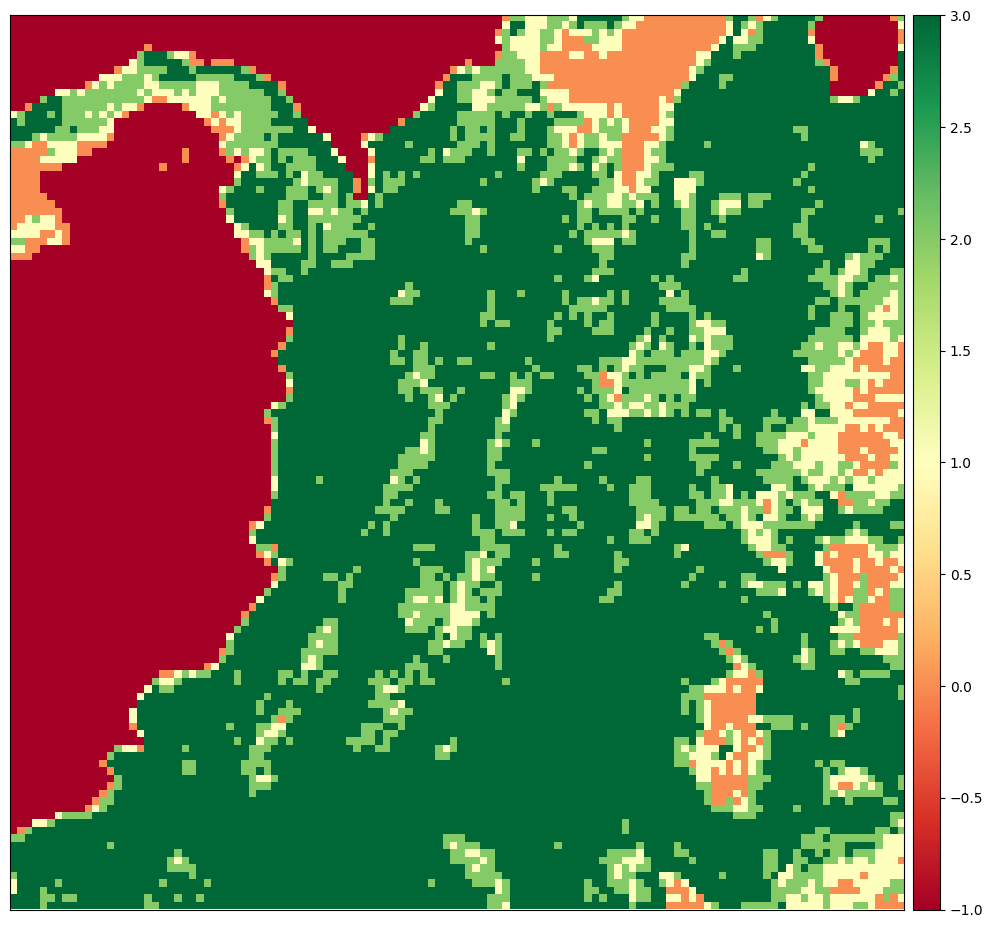

<Axes: >

In [ ]:
#--------------------------------------------------------------
# Quality
#--------------------------------------------------------------
"""
Quality
-1 - 0      Fill/No Data Not Processed
0  - 1      Good Data Use with confidence
1  - 0.5    Marginal data Useful, but look at other QA information
2  - 0      Snow/Ice Target covered with snow/ice
3  - 0      Cloudy Target not visible, covered with cloud

For the aggregation of qa data, I take the mean across the 10k block
"""
qa = hdf.select('250m 16 days pixel reliability')[:,:]
# good = ((qa == 0).astype(int) * 1)
# marginal = ((qa == 1).astype(int) * 0.5)
# snow = ((qa == 2).astype(int) * 0)
# cloudy = ((qa == 3).astype(int) * 0)
# # no_data = ((qa == -1).astype(int) * -1)
# no_data = ((qa == -1).astype(int) * 0)
# qa_transformed = good + marginal + snow + cloudy + no_data

period_agg = get_data_agg(
    data=qa,
    n_blocks_to_reduce=40,
    func='mean',
    )
print(qa.shape)
ep.plot_bands(qa, cmap='RdYlGn')

ep.plot_bands(period_agg, cmap='RdYlGn')

In [ ]:
def get_period_agg(path,):
    """
    Axis 2 order ['qa', 'std', 'mean', 'percentile_10', 'median', 'percentile_90']
    """
    km = 10
    m = km * 1000
    block_meters = 250
    n_blocks_to_reduce = int(m/block_meters)

    hdf = SD(path, SDC.READ)
    ndvi = hdf.select('250m 16 days NDVI')[:,:]

    qa = hdf.select('250m 16 days pixel reliability')[:,:]
    # good = ((qa == 0).astype(int) * 1)
    # marginal = ((qa == 1).astype(int) * 0.5)
    # snow = ((qa == 2).astype(int) * 0)
    # cloudy = ((qa == 3).astype(int) * 0)
    # # no_data = ((qa == -1).astype(int) * -1)
    # no_data = ((qa == -1).astype(int) * 0)
    # qa_transformed = good + marginal + snow + cloudy + no_data

    period_agg = get_data_agg(
        data=qa,
        n_blocks_to_reduce=n_blocks_to_reduce,
        func='mean',
        )[..., np.newaxis, np.newaxis]

    for i, (func, q) in enumerate(zip(
        [
            'std',
            'mean',
            'percentile',
            'percentile',
            'percentile',
            ],[
                None,
                None,
                10,
                50,
                90,
                ])):
        period_agg_subset = get_data_agg(
            data=ndvi,
            n_blocks_to_reduce=int(m/block_meters),
            func=func,
            q=q,
            )[..., np.newaxis, np.newaxis]
        period_agg = np.concatenate([period_agg, period_agg_subset], axis=2)

    return period_agg

period_agg = get_period_agg(path=paths_read[0])
period_agg.shape


(120, 120, 6, 1)

In [ ]:
ndvi_qa = get_period_agg(path=paths_read[0])
for path in tqdm(paths_read[1:]):
    period_agg = get_period_agg(path=path)
    ndvi_qa = np.concatenate([ndvi_qa, period_agg], axis=3)
print(f"ndvi_qa.shape: {ndvi_qa.shape}")

# save
path = '/content/drive/MyDrive/propane/data_agg/ndvi_qa.pickle'
with open(path, 'wb') as f:
    pickle.dump(ndvi_qa, f)

# save
path = '/content/drive/MyDrive/propane/data_agg/dates.pickle'
with open(path, 'wb') as f:
    pickle.dump(dates, f)

"""
shape = (n_10k_blocks, n_10k_blocks, metric, dates)
shape = (120, 120, 6, 1120)
axis 2 metric order ['qa', 'std', 'mean', 'percentile_10', 'median', 'percentile_90']
"""

100%|██████████| 559/559 [51:33<00:00,  5.53s/it]


ndvi_qa.shape: (120, 120, 6, 560)


"\nshape = (n_10k_blocks, n_10k_blocks, metric, dates)\nshape = (120, 120, 6, 1120)\naxis 2 metric order ['qa', 'std', 'mean', 'percentile_10', 'median', 'percentile_90']\n"

In [ ]:
ndvi_qa.shape

(120, 120, 6, 560)

In [ ]:
start_lat=52
stop_lat=62
start_lon=59
stop_lon=69

metrics_idx = {'qa':0, 'stddev':1, 'mean':2, 'percentile_10':3, 'median':4, 'percentile_90':5}
pd.Series(ndvi_qa[start_lon:stop_lon, start_lat:stop_lat, [metrics_idx['qa']], :].flatten()).value_counts()

3    18764
2    18520
1    12484
0     6232
Name: count, dtype: int64